# Dependent Density estimation
Use powerball dataset

In [1]:
%matplotlib inline
from IPython.display import HTML
from matplotlib import animation as ani, pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
from theano import shared, tensor as tt
import seaborn as sns



In [2]:
plt.rc('animation', writer='ffmpeg')
blue, *_ = sns.color_palette()
SEED = 972915 #from random.org
np.random.seed(SEED)


## Load dataset
LIDAR dataset from Larry Wasserman's book: All of non-parameteric statistics


In [3]:
DATA_URI = 'http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat'
def standardize(x):
    return (x - x.mean())/x.std()
df = (pd.read_csv(DATA_URI, sep=' *', engine='python')
     .assign(std_range=lambda df: standardize(df.range),
            std_logratio=lambda df: standardize(df.logratio)))
df.head()

C:\Anaconda3\envs\stpy35\lib\site-packages\pandas\io\parsers.py:2227: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Anaconda3\envs\stpy35\lib\site-packages\pandas\io\parsers.py:2229: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,range,logratio,std_logratio,std_range
0,390,-0.050356,0.852467,-1.717725
1,391,-0.060097,0.817981,-1.707299
2,393,-0.041901,0.882398,-1.686447
3,394,-0.050985,0.850240,-1.676020
4,396,-0.059913,0.818631,-1.655168


### Plot the data
Builds intuition

Text(0,0.5,'Standardized log ratio')

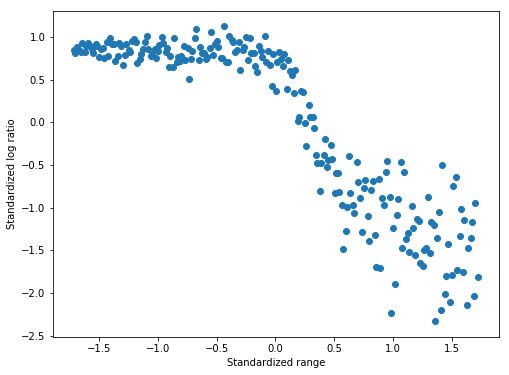

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df.std_range, df.std_logratio, c=blue)
ax.set_xlabel('Standardized range')
ax.set_ylabel('Standardized log ratio')

- The relationship between range and logratio is non-linear, but has local linear components
- The observation noise is heterskedastic, that is magnitude of the variance varies with range

The idea is to reduce the problem to many related density estimates conditioned on fixed values of predictors. Check the right hand plot of the animation

In [5]:
fig, (scatter, hist) = plt.subplots(ncols=2, figsize=(12,6))
scatter.scatter(df.std_range, df.std_logratio, c=blue, zorder=2)
scatter.set_xlabel('Standardize range')
scatter.set_ylabel('Standardize log ratio')
bins = np.linspace(df.std_range.min(), df.std_range.max(), 25)
hist.hist(df.std_logratio, bins=bins, color='green', alpha=.25, label='All data')
hist.set_xlabel('Standardized log ratio')
hist.set_ylabel('Frequency')
hist.legend(loc=2)

endpoints = np.linspace(1.05*df.std_range.min(), 1.05*df.std_range.max(), 15)
frame_artists = []
for l, h in zip(endpoints[:-1], endpoints[2:]):
    interval = scatter.axvspan(l, h, color='cyan', alpha=.3, zorder=1)
    *_, bars = hist.hist(df[df.std_range.between(l, h)].std_logratio, 
                         bins=bins,
                        color='gray',
                        alpha=.4)
    frame_artists.append((interval,) + tuple(bars))
    
animation = ani.ArtistAnimation(fig, frame_artists, interval=500, 
                                repeat_delay=3000, 
                               blit=True)
plt.close()


## Animation
For the following to work on my Windows:
- I installed ffmpeg: https://www.wikihow.com/Install-FFmpeg-on-Windows
- Then stopped and restarted the conda environment and jupyter notebook
- Make sure the python code plt.rc() uses 'ffmpeg' instead of 'avconv'

In [7]:
HTML(animation.to_html5_video())

In [8]:
import matplotlib
print(matplotlib.animation.writers.list(), matplotlib.__version__)

['ffmpeg_file', 'ffmpeg', 'html'] 2.1.1


### The Model

In [20]:
%%latex
\begin{align}
\alpha_1...\alpha_K \sim \mathcal{N}(0,5^2) \\
\beta_1...\beta_K \sim \mathcal{N}(0, 5^2) \\
v_i \Big| x \sim \mathcal{N} CDF ( \alpha_i + \beta_i * x ) \\
w_i \Big| x = v_i \Big|x \prod_{j=1}^{i-1}(1-v_j\Big|x) \\
\gamma_1...\gamma_K \sim \mathcal{N}(0, 10^2) \\
\delta_1...\delta_K \sim \mathcal{N}(0, 10^2) \\
\mu_i = (\gamma_i + \delta_i * x) \\
\tau_1...\tau_K \sim \Gamma(1,1) \\
obs \sim NormalMixture(w, \mu, \tau)\\
\end{align}


<IPython.core.display.Latex object>

In [21]:
#Normal CDF
def norm_cdf(z):
    return 0.5 * (1 + tt.erf(z/np.sqrt(2)))

def stick_breaking(v):
    return v * tt.concatenate([tt.ones_like(v[:, :1]), tt.extra_ops.cumprod(1 - v, axis=1)[:,:-1] ],
                             axis=1)

In [22]:
N=df.shape[0]
K=20
std_range = df.std_range.values[:, np.newaxis]
std_logratio = df.std_logratio.values[:, np.newaxis]
x_lidar = shared(std_range, broadcastable=(False, True))
with pm.Model() as model:
    alpha = pm.Normal('alpha', 0., 5., shape=K)
    beta = pm.Normal('beta', 0., 5., shape=K)
    v = norm_cdf(alpha + beta * x_lidar)
    w = pm.Deterministic('w', stick_breaking(v))

    gamma = pm.Normal('gamma', 0., 10., shape=K)
    delta = pm.Normal('delta', 0., 10., shape=K)
    mu = pm.Deterministic('mu', gamma + delta * x_lidar)
    tau = pm.Gamma('tau', 1., 1., shape=K)
    
    obs = pm.NormalMixture('obs', w, mu, tau=tau, observed=std_logratio)


In [23]:
with model:
    trace = pm.sample(2000, pm.Metropolis(), tune=1000, random_seed=SEED)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:07<00:00, 44.58it/s]


Text(0,0.5,'Mixture weight')

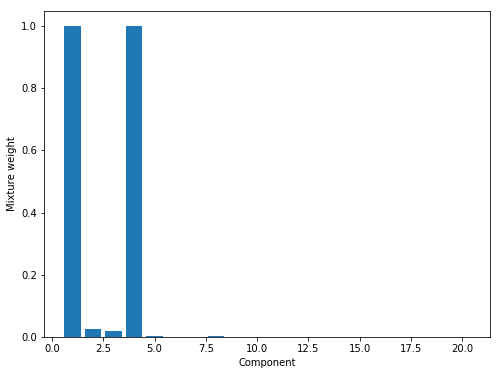

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(np.arange(K) + 1, trace['w'].mean(axis=0).max(axis=0))
ax.set_xlabel('Component')
ax.set_ylabel('Mixture weight')

### Only 4 major components
This is reasonable if we look at the distribution of the samples, as we can see three to four separate linear components

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:24<00:00, 59.40it/s]


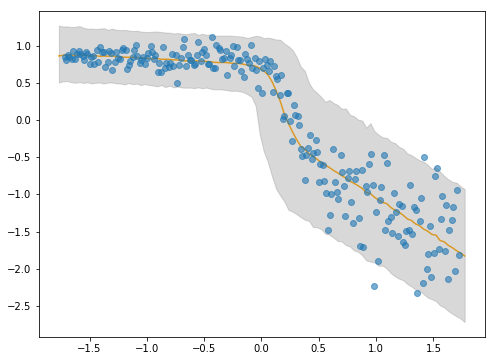

In [26]:
lidar_ppx_x = np.linspace(std_range.min()-0.05, std_range.max()+0.05, 100)
x_lidar.set_value(lidar_ppx_x[:, np.newaxis])
with model:
    ppc = pm.sample_ppc(trace, 5000, random_seed=SEED)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(std_range, std_logratio, c=blue, zorder=10, alpha=0.6)
    lo, hi = np.percentile(ppc['obs'], [2.5, 97.5], axis=0)
    ax.fill_between(lidar_ppx_x, lo, hi, color='gray', zorder=5, alpha=0.3)
    ax.plot(lidar_ppx_x, ppc['obs'].mean(axis=0), color='orange')

### Trials and tribulations
Do a conda install pydot, graphviz
Then, Add the path to dot.exe under graphviz (under Anaconda) to your system PATH variable
Then the following SVG call might work

<TensorType(float64, scalar)>
<TensorType(float64, scalar)> [id A]
Elemwise{add,no_inplace} [id A] ''   
 |Elemwise{mul,no_inplace} [id B] ''   
 | |TensorConstant{3} [id C]
 | |Elemwise{pow,no_inplace} [id D] ''   
 |   |<TensorType(float64, scalar)> [id E]
 |   |TensorConstant{2} [id F]
 |TensorConstant{1} [id G]


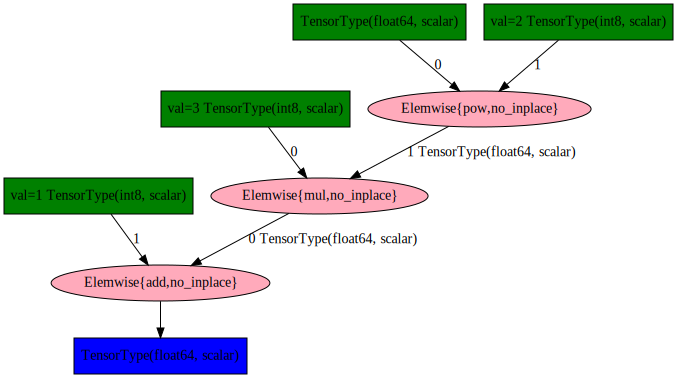

In [9]:
import pydot, theano
ax = theano.tensor.scalar()
print(ax)
theano.pprint(ax)
theano.printing.debugprint(ax)
from IPython.display import SVG
SVG(theano.printing.pydotprint(ax, return_image=True, format='svg'))

ay = 3*(ax**2) + 1
ay.eval({ax : 1})
theano.pprint(ay)
theano.printing.debugprint(ay)
SVG(theano.printing.pydotprint(ay, return_image=True, format='svg'))


# Miscellaneous
## A Zero Truncated Poisson
__Custom Probability Distribution in PyMC3__

In [ ]:
import theano.tensor as tt
from theano import function
from theano import printing
import pymc3 as pm

class ZeroTruncatedPoisson(pm.Discrete):
    '''
    Similar to a Poisson distribution, but the support is over positive integes 
    and so, excludes zero. An example, number of items in your grocery shopping cart
    at checkout
    '''
    def __init__(self, mu, *args, **kwargs):
        super(ZeroTruncatedPoisson, self).__init__(*args, **kwargs)
        self.mu = tt.as_tensor_variable(mu)
    
    def logp(self, value):
        '''
        compute total_log_probability
        '''
        return tt.sum(value * tt.log(self.mu) - tt.log(tt.exp(self.mu) -1) - tt.gammaln(value))
    
    def random(self, point=None, size=None):
        '''
        Generates a random sample from Zero Truncated Poisson
        '''
        k = 1
        mu = self.mu.tag.test_value
        t = tt.exp(-self.mu)/(1 - tt.exp(-self.mu))/(1. * self.mu)
        tn = t.tag.test_value
        s = tn
        u = np.random.uniform()
        while s < u:
            k = k + 1
            tn = tn * mu / k
            s = s + tn
            u = np.random.uniform()
        return k

In [ ]:
# If using a ZeroTruncatedPoisson
# obs = df_train['x1']
# with pm.Model() as zmodel:
#     mu = pm.HalfNormal('mu', sd=10.)
#     zp_poisson = ZeroTruncatedPoisson('zp', mu=mu, observed=obs)
#     ztrace = pm.sample(1000)
#     pm.plot_posterior(ztrace)
